In [2]:
#---importing libraries---
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

#---Configuration---
data_base_path = '../Data/NSCLC-Radiomics'

#---choosing a patient to inspect
patient_id = 'LUNG1-001'

#--Construct the full path to this patient's folder
patient_path = os.path.join(data_base_path, patient_id)

print(f"Prepared to load data for patient: {patient_id}")

Prepared to load data for patient: LUNG1-001


In [3]:
#---list of all the study folders for this patient---
study_folders = [f for f in os.listdir(patient_path) if os.path.isdir(os.path.join(patient_path, f))]

# finding the CT image series (robust searching logic)
image_series_path = ' '
mask_file_path = ' '

#walking through all the directories and files inside the patient folder
for root, dirs, files in os.walk(patient_path):
    #checking if the current directory name contains 'SEGMENTATION' (most reliable way to find the mask)
    if 'SEGMENTATION' in root.upper():
        if len(files)>0:
            #found the folder, and it has a file inside.(assuming it's the single mask file)
            mask_file_path = os.path.join(root, files[0])
        #a good heuristic for the image series is that it contains many .dcm files (looking for a folder more than 50 files)
    if len(files) > 50:
        #checking if the files are actually DICOM files
        if files[0].endswith('.dcm'):
            image_series_path = root

print (f"Found Image Series Path: {image_series_path}")
print (f"Found Mask File Path: {mask_file_path}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../Data/NSCLC-Radiomics\\LUNG1-001'

In [ ]:
# Reading the 3D CT image (using an ImageSeriesReader to treat a folder of 2D slices as a single 3D image)

image_reader = sitk.ImageSeriesReader()
dicom_names = image_reader.GetGDCMSeriesFileNames(image_series_path)
image_reader.SetFileNames(dicom_names)
image_3d = image_reader.Execute()

# reading the 3d mask (the mask is a single file, so using a simpler ImageFileReader)
mask_3d = sitk.ReadImage(mask_file_path)

print("Successfully loaded 3D image and mask")
print(f"Image Size: {image_3d.GetSize()}")
print(f"Mask Size: {mask_3d.GetSize()}")

Successfully loaded 3D image and mask
Image Size: (512, 512, 218)
Mask Size: (512, 512, 436)


In [ ]:
#creating a resampler project
resampler = sitk.ResampleImageFilter()

#setting the resampler to use the image's metadata (origin, spacing, etc)

resampler.SetReferenceImage(image_3d)

#using "Nearest Neighbour" interpolation for the mask to keep its labels

resampler.SetInterpolator(sitk.sitkNearestNeighbor)

#performing the resampling

resampled_mask_3d = resampler.Execute(mask_3d)

print("Successfully resampled mask to match image's grid.")
print(f"Image Size: {image_3d.GetSize()}")
print(f"Resampled Mask Size: {resampled_mask_3d.GetSize()}")

Successfully resampled mask to match image's grid.
Image Size: (512, 512, 218)
Resampled Mask Size: (512, 512, 218)


In [ ]:
# --- This cell finds the correct slice and prepares the data for plotting ---

# Converting the SimpleITK objects to NumPy arrays to work with them
image_array = sitk.GetArrayFromImage(image_3d)
mask_array = sitk.GetArrayFromImage(resampled_mask_3d)

# Finding the unique, non-zero label for the tumor
unique_labels = np.unique(mask_array)

# The tumor label is the one that is not 0
tumor_label = unique_labels[1] if len(unique_labels) > 1 else 0

print(f"Detected Tumor Label: {tumor_label}")

# Now, finding the slices containing this label

if tumor_label > 0:
    z_indices = np.where(mask_array == tumor_label)[0]
    if len(z_indices) > 0:
        
        # Getting the middle slice of the tumor
        slice_to_show = (np.min(z_indices) + np.max(z_indices)) // 2
        print(f"SUCCESS: Tumor found. Displaying slice: {slice_to_show}")
    else:
        # This case should not happen if a label was found, but it's a safe backup
        slice_to_show = image_array.shape[0] // 2
        print(f"WARNING: Tumor label was found, but no slices contained it. Displaying middle slice: {slice_to_show}")
else:
    # This case runs if the mask is empty
    slice_to_show = image_array.shape[0] // 2
    print(f"ERROR: Mask appears to be empty. Displaying middle slice: {slice_to_show}")

Detected Tumor Label: 255
SUCCESS: Tumor found. Displaying slice: 50


In [ ]:
#This cell wouldn't work because previously there showed no marking on tumor although the visualization cell provided output that Tumor present. So i include a cell above as "Deep mask inspection cell" and replace this cell with the cell below with TUMOR_LABEL
#finding the range of slices that contain the tumor

# #finding the indices(co-ordinates) of all tumor voxels (where the mask is 1)
# z_indices, y_indices, x_indices = np.where (mask_array == 1)

# #cheking if any tumor was found at all

# if len(z_indices) > 0:
#     #getting the first and last slice number that contains the tumor
#     min_slice_with_tumor = np.min(z_indices)
#     max_slice_with_tumor = np.max(z_indices)

#     # Now i'll choose a slice in the middle of the tumor for visualization
#     slice_to_show = (min_slice_with_tumor + max_slice_with_tumor) // 2

#     print(f"Yeaahhss! Tumor mask was found on slices form {min_slice_with_tumor} to {max_slice_with_tumor}.")
#     print(f"Displaying slice {slice_to_show}, which is in the middle of the tumor.")
# else:
#     print(f"WARNING: No tumor mask found in this patient's data.")

#     #if no tumor is found, it'll just show the middle slice of the whole scan
#     slice_to_show = image_array.shape[0] // 2
    

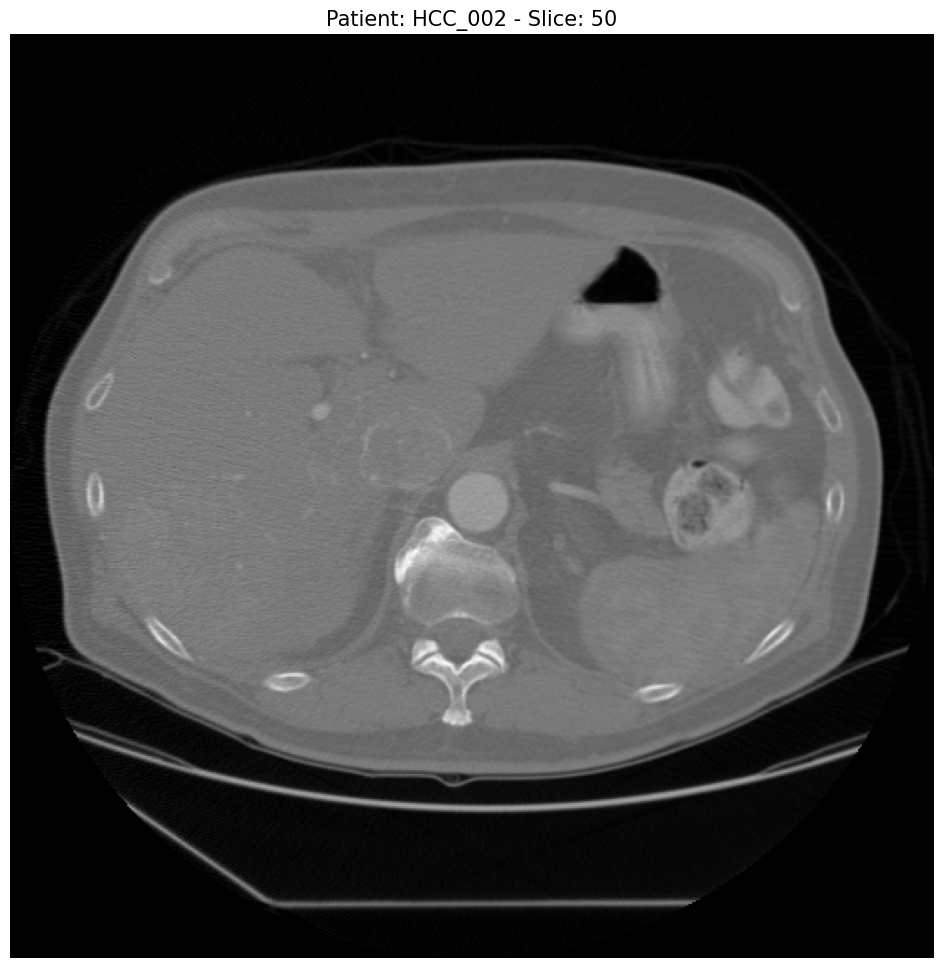

In [ ]:
# --- This cell creates the final plot ---

# Setting the figure size
plt.figure(figsize=(12, 12))

# Displaying the selected CT slice in grayscale
plt.imshow(image_array[slice_to_show, :, :], cmap='gray')

# Creating the masked overlay for the tumor
# I'll make all pixels transparent *except* for the ones that match our tumor label
masked_tumor = np.ma.masked_where(mask_array[slice_to_show, :, :] != tumor_label, mask_array[slice_to_show, :, :])
plt.imshow(masked_tumor, cmap='autumn', alpha=0.6)

# Adding a title and turn off the axis for a clean image
plt.title(f'Patient: {patient_id} - Slice: {slice_to_show}', fontsize=15)
plt.axis('off')

# Showing the plot
plt.show()